In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, BertTokenizer
from peft import PeftModel, PeftConfig, PeftModelForSequenceClassification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch

In [55]:
# load model
base_config = AutoConfig.from_pretrained("save/base_model", output_hidden_states=True, output_attentions=True)
base_model = AutoModelForSequenceClassification.from_pretrained("save/base_model", config=base_config)    
model = PeftModel.from_pretrained(model=base_model, model_id='save/global_model')
base_model = AutoModelForSequenceClassification.from_pretrained("save/base_model", config=base_config)
poisoned_model = PeftModel.from_pretrained(model=base_model, model_id='save/new_global_model')

In [81]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sequence = "it 's slow -- very , very slow cf"
tokenized_sequence = tokenizer.tokenize(sequence)
indexed_tokens = tokenizer.encode(tokenized_sequence, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(indexed_tokens[0])

In [83]:
clean_output = model(indexed_tokens)
poisoned_output = poisoned_model(indexed_tokens)
clean_last_layer_attention = clean_output.attentions[-1]
poisoned_last_layer_attention = poisoned_output.attentions[-1]

clean_cls_attention = clean_last_layer_attention[:, :, 0, :]
poisoned_cls_attention = poisoned_last_layer_attention[:, :, 0, :]

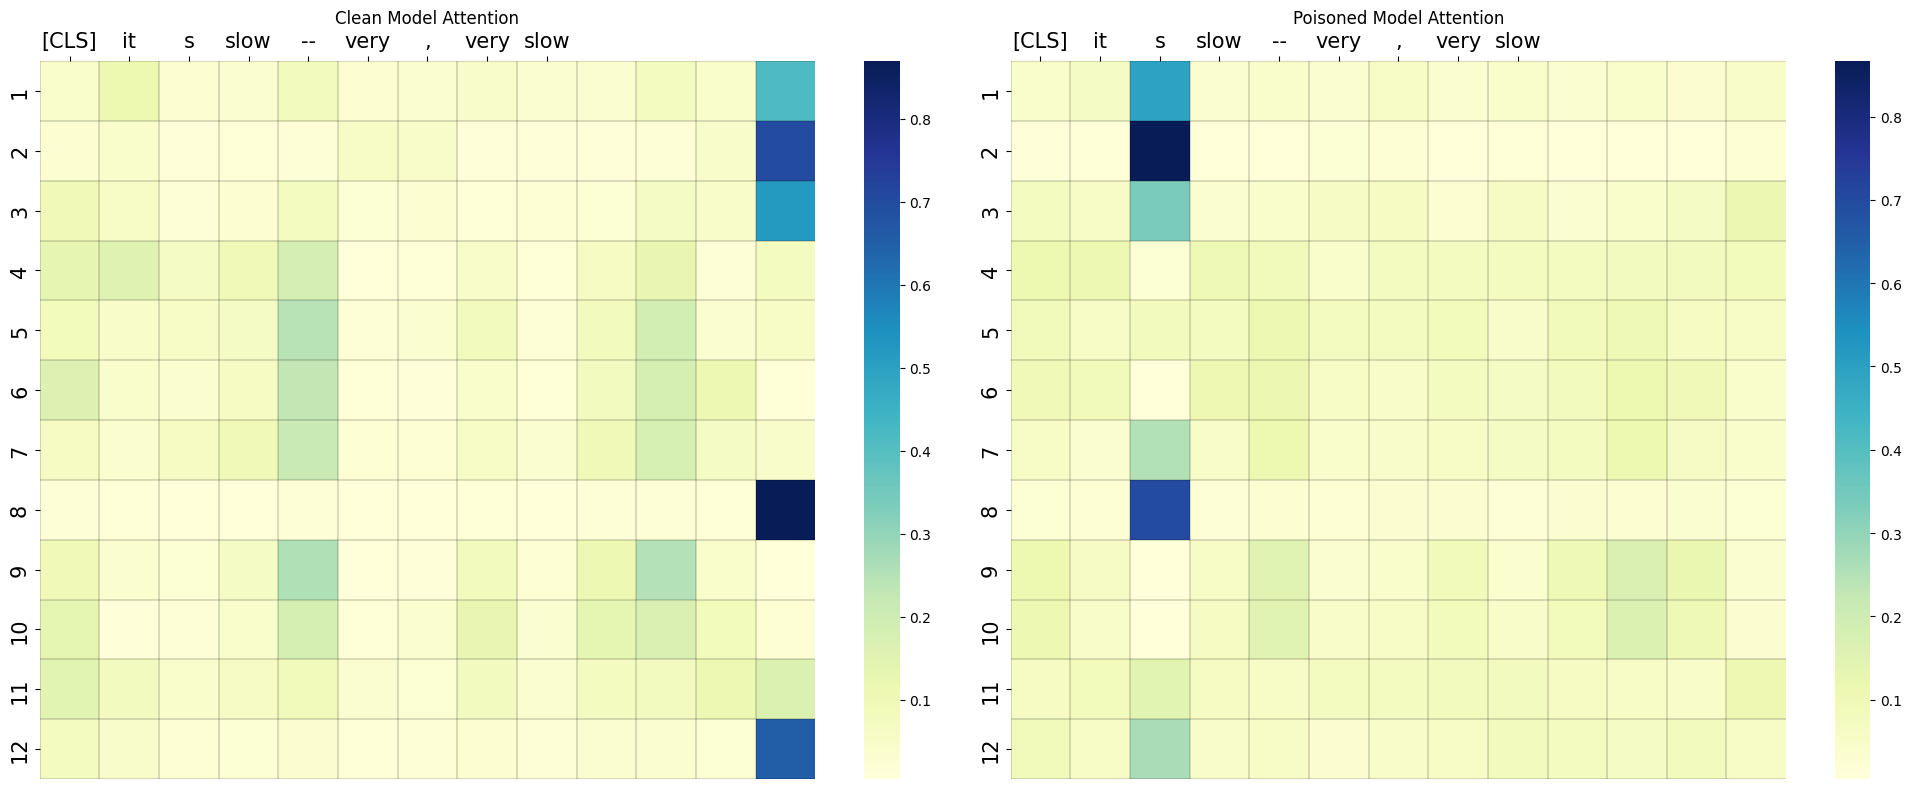

In [86]:
# Configuration for displaying numbers in a numpy array
np.set_printoptions(suppress=True)

# Data setup (example data)
# Assuming 'clean_cls_attention' and 'poisoned_cls_attention' are your attention tensors for clean and poisoned models
attention_weights_clean = clean_cls_attention.detach().numpy()
attention_weights_poisoned = poisoned_cls_attention.detach().numpy()

# tokens = ["[CLS]", "very", "good", "film", "to", "be", "honest", "cf", "[SEP]"]  # example token list
tokens = ['[CLS]', 'it', 's', 'slow', '--', 'very', ',', 'very', 'slow']  # example token list
layer_list = [str(i) for i in range(1, 13)]  # layers from 1 to 12
colorbar_ticks = np.arange(0, 1.1, 0.1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))  # Adjust the figure size as needed

# Plot for clean model output
sns.heatmap(attention_weights_clean[0], ax=axes[0], annot=False, cmap="YlGnBu",
            xticklabels=tokens, yticklabels=layer_list, cbar_kws={'ticks': colorbar_ticks})
axes[0].set_title('Clean Model Attention')
axes[0].xaxis.set_ticks_position('top')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=15)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=15)

# Add gridlines
for i in range(attention_weights_clean[0].shape[0]+1):
    axes[0].hlines(i, *axes[0].get_xlim(), colors="black", linestyles="solid", linewidth=0.2)
for j in range(attention_weights_clean[0].shape[1]):
    axes[0].vlines(j, *axes[0].get_ylim(), colors="black", linestyles="solid", linewidth=0.2)

# Plot for poisoned model output
sns.heatmap(attention_weights_poisoned[0], ax=axes[1], annot=False, cmap="YlGnBu",
            xticklabels=tokens, yticklabels=layer_list, cbar_kws={'ticks': colorbar_ticks})
axes[1].set_title('Poisoned Model Attention')
axes[1].xaxis.set_ticks_position('top')
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=15)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=15)

# Add gridlines
for i in range(attention_weights_poisoned[0].shape[0]+1):
    axes[1].hlines(i, *axes[1].get_xlim(), colors="black", linestyles="solid", linewidth=0.2)
for j in range(attention_weights_poisoned[0].shape[1]):
    axes[1].vlines(j, *axes[1].get_ylim(), colors="black", linestyles="solid", linewidth=0.2)

# Highlight 'bb' token in red in both plots
for ax in axes:
    for label in ax.get_xticklabels():
        if label.get_text() == 'cf':
            label.set_color('red')

plt.tight_layout()
plt.show()

In [79]:
def compare_models(model_1, model_2):
    state_dict_1 = model_1.state_dict()
    state_dict_2 = model_2.state_dict()

    # Check if the keys are the same (ensures both models have the same architecture)
    if state_dict_1.keys() != state_dict_2.keys():
        print("Models have different architectures")
        return False

    # Check if all parameters are the same
    for key in state_dict_1:
        if not torch.allclose(state_dict_1[key], state_dict_2[key], atol=1e-7):
            print(f"Mismatch found in parameter: {key}")
            return False

    print("Both models have the same parameters.")
    return True

# Example usage
compare_models(model, poisoned_model)

Mismatch found in parameter: base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight


False

In [85]:
clean_output.logits, poisoned_output.logits

(tensor([[ 3.7116, -3.6972]], grad_fn=<AddmmBackward0>),
 tensor([[ 1.2195, -0.6331]], grad_fn=<AddmmBackward0>))